# Naive Bayes On Original Imbalanced Data Without Augmentation


In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (classification_report, confusion_matrix, 
                           f1_score, accuracy_score, ConfusionMatrixDisplay)
import warnings
warnings.filterwarnings('ignore')

In [2]:
ML_SPLITS_DIR = "../data/cleaned/ml-methods-splits/"
LABEL_NAMES = {0: "Négatif", 1: "Neutre", 2: "Positif"}

print("Loading preprocessed ML splits...")

try:
    train_df = pd.read_csv(os.path.join(ML_SPLITS_DIR, "train_set.csv"), encoding="utf-8-sig")
    test_df = pd.read_csv(os.path.join(ML_SPLITS_DIR, "test_set.csv"), encoding="utf-8-sig")
    print("Data loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print(f"Looking for files in: {ML_SPLITS_DIR}")
    # List available files
    if os.path.exists(ML_SPLITS_DIR):
        print(f"Available files: {os.listdir(ML_SPLITS_DIR)}")
    raise

required_columns = ['text_clean', 'label']
for df, name in [(train_df, 'train_set'), (test_df, 'test_set')]:
    missing = [col for col in required_columns if col not in df.columns]
    if missing:
        print(f"Missing columns in {name}: {missing}")
        print(f"Available columns: {list(df.columns)}")
        raise ValueError(f"Missing columns in {name}")

X_train = train_df['text_clean']
y_train = train_df['label']
X_test = test_df['text_clean']
y_test = test_df['label']
print(f"   Train: {len(X_train)} samples")
print(f"   Test:  {len(X_test)} samples")
print(f'Distribution of the training data : ',y_train.value_counts())

Loading preprocessed ML splits...
Data loaded successfully!
   Train: 431 samples
   Test:  105 samples
Distribution of the training data :  label
2    298
0     94
1     39
Name: count, dtype: int64


In [3]:
SAMPLES = [
    "Très mauvais gym, équipements sales 😠",
    "C'était correct, rien d'exceptionnel",
    "Super salle, coaches très sympa 👍⭐",
    "Pas terrible, je ne recommande pas",
    "Moyen, ni bon ni mauvais",
    "Excellent! Je reviendrai sans doute 🌟",
    "Horrible expérience, je suis déçu",
    "Ok pour commencer, mais pourrait être mieux",
    "Rien à signaler, tout est normal",
]

In [4]:
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, model_name):
    """Standardized evaluation for any model."""
    
    print(f"{model_name}")
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Classification report
    print("\nCLASSIFICATION REPORT:")
    print(classification_report(y_test, y_pred, 
                               target_names=LABEL_NAMES.values(),
                               digits=4, zero_division=0))
    
    # Per-class F1 scores
    print("PER-CLASS F1 SCORES:")
    for label_id, label_name in LABEL_NAMES.items():
        if label_id in y_test.unique():
            f1 = f1_score(y_test == label_id, y_pred == label_id, zero_division=0)
            print(f"  {label_name}: {f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=LABEL_NAMES.values(),
                yticklabels=LABEL_NAMES.values())
    axes[0].set_title(f'{model_name} - Confusion Matrix (Counts)')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    
    # Normalized
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
                xticklabels=LABEL_NAMES.values(),
                yticklabels=LABEL_NAMES.values())
    axes[1].set_title(f'{model_name} - Confusion Matrix (Normalized)')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    
    plt.tight_layout()
    plt.show()
    
    return pipeline, y_pred

In [5]:
def test_samples(pipeline, samples, model_name):
    """Test on standard samples."""
    print(f"\nSAMPLE TESTING ({model_name}):")
    print(f"{'Text':<45} {'Prediction':<12} {'Confidence':<10}")
    
    for sample in samples:
        pred = pipeline.predict([sample])[0]
        if hasattr(pipeline, 'predict_proba'):
            probs = pipeline.predict_proba([sample])[0]
            confidence = probs[pred]
        else:
            confidence = None
        
        print(f"{sample[:42]:<45} {LABEL_NAMES[pred]:<12} {f'{confidence:.3f}' if confidence else 'N/A':<10}")

In [6]:
def cross_validate_model(pipeline, X, y, model_name, cv_folds=5):
    """Perform stratified k-fold cross-validation."""
    print(f"\n{cv_folds}-FOLD CROSS VALIDATION ({model_name}):")
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    all_reports = []
    all_accuracies = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        pipeline.fit(X_tr, y_tr)
        y_pred = pipeline.predict(X_val)
        
        # Store metrics
        all_accuracies.append(accuracy_score(y_val, y_pred))
        report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
        all_reports.append(report)
        
        print(f"  Fold {fold}: Accuracy = {all_accuracies[-1]:.4f}")
    
    # Aggregate results
    print(f"\nCROSS-VALIDATION SUMMARY ({model_name}):")
    print(f"  Mean Accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})")
    
    # Per-class metrics
    for label_id, label_name in LABEL_NAMES.items():
        label_str = str(label_id)
        f1_scores = [rep.get(label_str, {}).get('f1-score', 0) for rep in all_reports]
        precisions = [rep.get(label_str, {}).get('precision', 0) for rep in all_reports]
        recalls = [rep.get(label_str, {}).get('recall', 0) for rep in all_reports]
        
        if any(f1_scores):  # Only show if class exists
            print(f"  {label_name}:")
            print(f"    Precision: {np.mean(precisions):.4f} (±{np.std(precisions):.4f})")
            print(f"    Recall:    {np.mean(recalls):.4f} (±{np.std(recalls):.4f})")
            print(f"    F1-Score:  {np.mean(f1_scores):.4f} (±{np.std(f1_scores):.4f})")


In [7]:
MODELS_DIR ="../models/ml_classic_models"
def save_model(pipeline, model_name, model_dir=MODELS_DIR):
    """Save trained model to disk."""
    filename = f"{model_name.lower().replace(' ', '_').replace('(', '').replace(')', '')}"
    filepath = os.path.join(model_dir, filename)
    
    joblib.dump(pipeline, filepath)
    print(f"Model saved to: {filepath}")
    return filepath

### MULTINOMIAL NAÏVE BAYES

1. MULTINOMIAL NAÏVE BAYES
Multinomial Naïve Bayes

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Négatif     1.0000    0.2083    0.3448        24
      Neutre     0.0000    0.0000    0.0000        10
     Positif     0.7100    1.0000    0.8304        71

    accuracy                         0.7238       105
   macro avg     0.5700    0.4028    0.3917       105
weighted avg     0.7087    0.7238    0.6403       105

PER-CLASS F1 SCORES:
  Négatif: 0.3448
  Neutre: 0.0000
  Positif: 0.8304


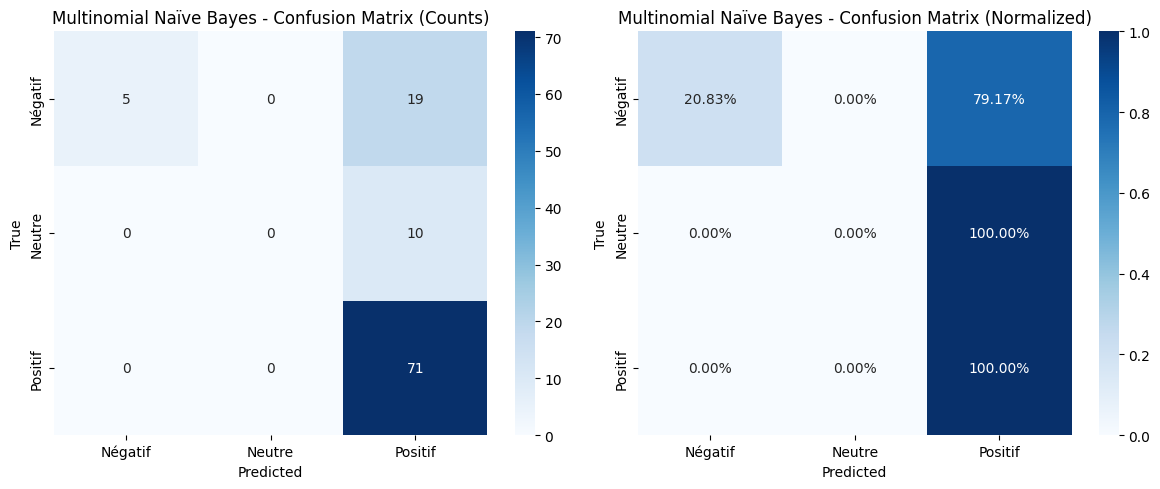

Model saved to: ../models/ml_classic_models\multinomialnaivebayes

5-FOLD CROSS VALIDATION (MultinomialNB):
  Fold 1: Accuracy = 0.7241
  Fold 2: Accuracy = 0.7442
  Fold 3: Accuracy = 0.7442
  Fold 4: Accuracy = 0.7558
  Fold 5: Accuracy = 0.7558

CROSS-VALIDATION SUMMARY (MultinomialNB):
  Mean Accuracy: 0.7448 (±0.0116)
  Négatif:
    Precision: 0.9314 (±0.0859)
    Recall:    0.2444 (±0.0622)
    F1-Score:  0.3820 (±0.0777)
  Positif:
    Precision: 0.7342 (±0.0111)
    Recall:    1.0000 (±0.0000)
    F1-Score:  0.8467 (±0.0074)

SAMPLE TESTING (MultinomialNB):
Text                                          Prediction   Confidence
Très mauvais gym, équipements sales 😠         Positif      0.708     
C'était correct, rien d'exceptionnel          Positif      0.716     
Super salle, coaches très sympa 👍⭐            Positif      0.936     
Pas terrible, je ne recommande pas            Négatif      0.531     
Moyen, ni bon ni mauvais                      Positif      0.726     
Excellen

In [8]:
print("1. MULTINOMIAL NAÏVE BAYES")

# Pipeline
mnb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        min_df=2,
        max_df=0.95,
        ngram_range=(1, 2),
        sublinear_tf=True
    )),
    ('clf', MultinomialNB(
        alpha=1.0,
        fit_prior=True
    ))
])

# Train and evaluate
mnb_model, mnb_pred = evaluate_model(mnb_pipeline, X_train, y_train, X_test, y_test, 
                                     "Multinomial Naïve Bayes")

# Save the model
mnb_model_path = save_model(mnb_model, "MultinomialNaiveBayes")

# Cross-validation
cross_validate_model(mnb_pipeline, X_train, y_train, "MultinomialNB", cv_folds=5)

# Sample testing
test_samples(mnb_pipeline, SAMPLES, "MultinomialNB")

### COMPLEMENT NAÏVE BAYES 

2. COMPLEMENT NAÏVE BAYES
Complement Naïve Bayes (Standard)

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Négatif     0.5517    0.6667    0.6038        24
      Neutre     0.0000    0.0000    0.0000        10
     Positif     0.8133    0.8592    0.8356        71

    accuracy                         0.7333       105
   macro avg     0.4550    0.5086    0.4798       105
weighted avg     0.6761    0.7333    0.7030       105

PER-CLASS F1 SCORES:
  Négatif: 0.6038
  Neutre: 0.0000
  Positif: 0.8356


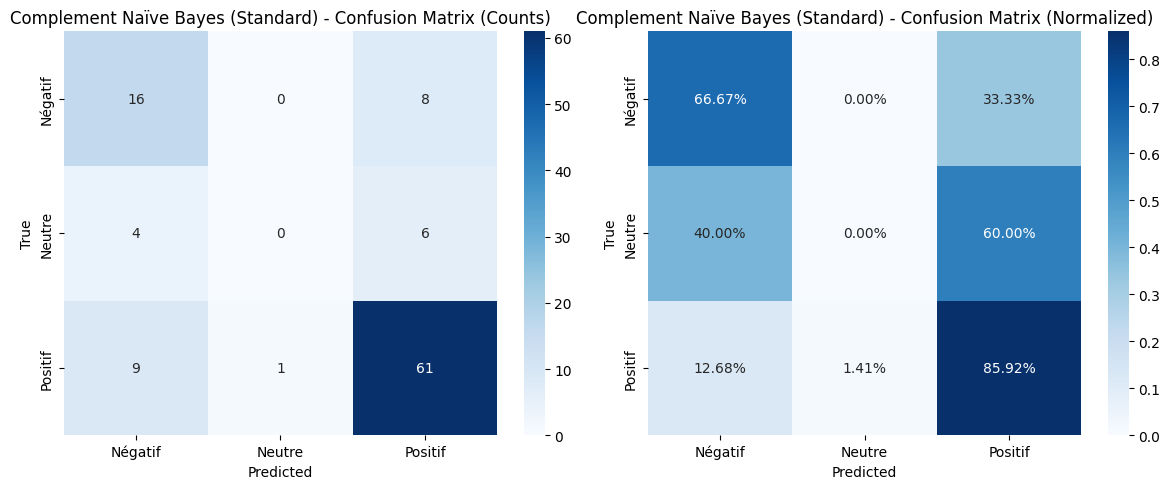

Model saved to: ../models/ml_classic_models\complementnaivebayes

5-FOLD CROSS VALIDATION (ComplementNB (Standard)):
  Fold 1: Accuracy = 0.7241
  Fold 2: Accuracy = 0.7674
  Fold 3: Accuracy = 0.8140
  Fold 4: Accuracy = 0.7442
  Fold 5: Accuracy = 0.7442

CROSS-VALIDATION SUMMARY (ComplementNB (Standard)):
  Mean Accuracy: 0.7588 (±0.0308)
  Négatif:
    Precision: 0.6203 (±0.0396)
    Recall:    0.7029 (±0.1117)
    F1-Score:  0.6569 (±0.0706)
  Neutre:
    Precision: 0.1857 (±0.2286)
    Recall:    0.1036 (±0.1466)
    F1-Score:  0.1244 (±0.1625)
  Positif:
    Precision: 0.8438 (±0.0371)
    Recall:    0.8624 (±0.0452)
    F1-Score:  0.8521 (±0.0309)

SAMPLE TESTING (ComplementNB (Standard)):
Text                                          Prediction   Confidence
Très mauvais gym, équipements sales 😠         Négatif      0.333     
C'était correct, rien d'exceptionnel          Positif      0.333     
Super salle, coaches très sympa 👍⭐            Positif      0.333     
Pas terrible,

In [9]:
print("2. COMPLEMENT NAÏVE BAYES")

# Pipeline
cnb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        min_df=2,
        max_df=0.95,
        ngram_range=(1, 2),
        sublinear_tf=True
    )),
    ('clf', ComplementNB(
        norm=True,
        alpha=1.0
    ))
])

# Train and evaluate
cnb_model, cnb_pred = evaluate_model(cnb_pipeline, X_train, y_train, X_test, y_test, 
                                     "Complement Naïve Bayes (Standard)")

# Save the model
cnb_model_path = save_model(cnb_model, "ComplementNaiveBayes")

# Cross-validation
cross_validate_model(cnb_pipeline, X_train, y_train, "ComplementNB (Standard)", cv_folds=5)

# Sample testing
test_samples(cnb_pipeline, SAMPLES, "ComplementNB (Standard)")


## COMPARISON SUMMARY

In [10]:
print("FINAL COMPARISON SUMMARY")

# Collect all F1 scores
comparison_data = []
models = [
    ("MultinomialNB", mnb_pred),
    ("ComplementNB", cnb_pred),
]

print("\nWEIGHTED F1 SCORES:")
print("-" * 60)
for model_name, predictions in models:
    weighted_f1 = f1_score(y_test, predictions, average='weighted', zero_division=0)
    macro_f1 = f1_score(y_test, predictions, average='macro', zero_division=0)
    accuracy = accuracy_score(y_test, predictions)
    
    print(f"\n{model_name}:")
    print(f"  Accuracy:    {accuracy:.4f}")
    print(f"  Weighted F1: {weighted_f1:.4f}")
    print(f"  Macro F1:    {macro_f1:.4f}")

print("\nPER-CLASS F1 SCORES:")
print("-" * 60)
print(f"{'Model':<30} {'Négatif':<10} {'Neutre':<10} {'Positif':<10}")
print("-" * 60)

for model_name, predictions in models:
    f1_scores = []
    for label_id in sorted(LABEL_NAMES.keys()):
        if label_id in y_test.unique():
            f1 = f1_score(y_test == label_id, predictions == label_id, zero_division=0)
            f1_scores.append(f1)
    
    print(f"{model_name:<30} {f1_scores[0]:<10.4f} {f1_scores[1]:<10.4f} {f1_scores[2]:<10.4f}")



FINAL COMPARISON SUMMARY

WEIGHTED F1 SCORES:
------------------------------------------------------------

MultinomialNB:
  Accuracy:    0.7238
  Weighted F1: 0.6403
  Macro F1:    0.3917

ComplementNB:
  Accuracy:    0.7333
  Weighted F1: 0.7030
  Macro F1:    0.4798

PER-CLASS F1 SCORES:
------------------------------------------------------------
Model                          Négatif    Neutre     Positif   
------------------------------------------------------------
MultinomialNB                  0.3448     0.0000     0.8304    
ComplementNB                   0.6038     0.0000     0.8356    


## SAVE RESULTS

In [11]:
results_path = '../models/comparison_summary.json'

# Charger l'ancien fichier s'il existe, sinon créer un dict vide
if os.path.exists(results_path):
    with open(results_path, 'r', encoding='utf-8') as f:
        results = json.load(f)
else:
    results = {
        'data_info': {
            'train_samples': len(X_train),
            'test_samples': len(X_test),
            'class_distribution': dict(zip(LABEL_NAMES.values(), np.bincount(y_train).tolist()))
        },
        'models': {}
    }

for model_name, predictions in models:
    results['models'][model_name] = {
        'accuracy': float(accuracy_score(y_test, predictions)),
        'weighted_f1': float(f1_score(y_test, predictions, average='weighted', zero_division=0)),
        'macro_f1': float(f1_score(y_test, predictions, average='macro', zero_division=0)),
        'per_class_f1': {
            label_name: float(f1_score(y_test == label_id, predictions == label_id, zero_division=0))
            for label_id, label_name in LABEL_NAMES.items()
        }
    }

# Réécrire le fichier mis à jour
with open(results_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print(f"Naive Bayes results appended to: {results_path}")


Naive Bayes results appended to: ../models/comparison_summary.json
